In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


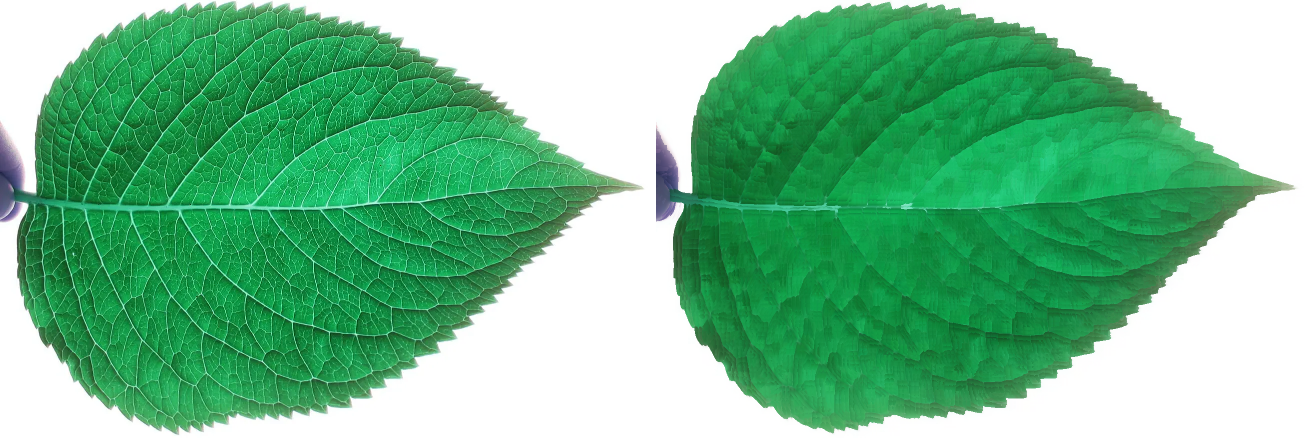

In [ ]:
import numpy as np
import cv2
from numba import cuda
import numba
from google.colab.patches import cv2_imshow
@cuda.jit
def kuwahara_kernel(r, g, b, output_r, output_g, output_b, height, width, omega):
    x, y = cuda.grid(2)
    if x >= width or y >= height:
        return

    means_r = cuda.local.array(4, numba.float32)
    means_g = cuda.local.array(4, numba.float32)
    means_b = cuda.local.array(4, numba.float32)
    variances = cuda.local.array(4, numba.float32)
    counts = cuda.local.array(4, numba.int32)

    for k in range(4):
        means_r[k] = 0.0
        means_g[k] = 0.0
        means_b[k] = 0.0
        variances[k] = 0.0
        counts[k] = 0

    for dx in range(-omega, omega + 1):
        for dy in range(-omega, omega + 1):
            ni, nj = y + dy, x + dx
            if ni >= 0 and nj >= 0 and ni < height and nj < width:
                val_r = r[ni, nj]
                val_g = g[ni, nj]
                val_b = b[ni, nj]

                if dy <= 0 and dx <= 0:
                    means_r[0] += val_r
                    means_g[0] += val_g
                    means_b[0] += val_b
                    variances[0] += val_b * val_b
                    counts[0] += 1
                if dy <= 0 and dx >= 0:
                    means_r[1] += val_r
                    means_g[1] += val_g
                    means_b[1] += val_b
                    variances[1] += val_b * val_b
                    counts[1] += 1
                if dy >= 0 and dx <= 0:
                    means_r[2] += val_r
                    means_g[2] += val_g
                    means_b[2] += val_b
                    variances[2] += val_b * val_b
                    counts[2] += 1
                if dy >= 0 and dx >= 0:
                    means_r[3] += val_r
                    means_g[3] += val_g
                    means_b[3] += val_b
                    variances[3] += val_b * val_b
                    counts[3] += 1

    for k in range(4):
        if counts[k] > 0:
            means_r[k] /= counts[k]
            means_g[k] /= counts[k]
            means_b[k] /= counts[k]
            variances[k] = (variances[k] / counts[k]) - (means_b[k] * means_b[k])

    min_k = 0
    min_variance = variances[0]
    for k in range(1, 4):
        if variances[k] < min_variance:
            min_variance = variances[k]
            min_k = k

    output_r[y, x] = means_r[min_k]
    output_g[y, x] = means_g[min_k]
    output_b[y, x] = means_b[min_k]

def kuwahara_filter(image, omega):
    r, g, b = cv2.split(image.astype(np.float32))

    r_gpu = cuda.to_device(r)
    g_gpu = cuda.to_device(g)
    b_gpu = cuda.to_device(b)
    output_r = cuda.device_array(r.shape, dtype=np.float32)
    output_g = cuda.device_array(g.shape, dtype=np.float32)
    output_b = cuda.device_array(b.shape, dtype=np.float32)

    height, width = r.shape
    threads_per_block = (16, 16)
    blocks_per_grid = ((width + threads_per_block[0] - 1) // threads_per_block[0],
                       (height + threads_per_block[1] - 1) // threads_per_block[1])

    kuwahara_kernel[blocks_per_grid, threads_per_block](r_gpu, g_gpu, b_gpu, output_r, output_g, output_b, height, width, omega)

    filtered_r = output_r.copy_to_host().astype(np.uint8)
    filtered_g = output_g.copy_to_host().astype(np.uint8)
    filtered_b = output_b.copy_to_host().astype(np.uint8)

    r_gpu = g_gpu = b_gpu = output_r = output_g = output_b = None

    filtered_image = cv2.merge([filtered_r, filtered_g, filtered_b])

    return filtered_image

image_path = '/content/gdrive/MyDrive/HPC/Proj/leaf_area.jpg'
image = cv2.imread(image_path)
if image is None:
    raise FileNotFoundError(f"Image at path '{image_path}' not found.")
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
filtered_image = kuwahara_filter(image_rgb, omega=8)

height, width = image_rgb.shape[:2]
filtered_image_resized = cv2.resize(filtered_image, (width // 2, height // 2))
image_rgb_resized = cv2.resize(image_rgb, (width // 2, height // 2))

concatenated_image = np.concatenate((image_rgb_resized, filtered_image_resized), axis=1)
cv2_imshow(concatenated_image)


In [ ]:
import time

def measure_performance(image, omega_values):
    timings = {}
    for omega in omega_values:
        start_time = time.time()

        filtered_image = kuwahara_filter(image, omega=omega)

        end_time = time.time()
        time_taken = end_time - start_time
        timings[omega] = time_taken

    return timings

omega_values = [1, 3, 5, 7, 9]

performance_timings = measure_performance(image_rgb, omega_values)

print("\nPerformance Timings for Different Omega Values:")
for omega, timing in performance_timings.items():
    print(f"Omega: {omega}, Time: {timing:.4f} seconds")


Performance Timings for Different Omega Values:
Omega: 1, Time: 0.0767 seconds
Omega: 3, Time: 0.0675 seconds
Omega: 5, Time: 0.0812 seconds
Omega: 7, Time: 0.0648 seconds
Omega: 9, Time: 0.0659 seconds
